### The "Best" Model

This module was all about regression and using Python's scikitlearn library to build regression models.  Below, a dataset related to real estate prices in California is given. While many of the assignments you have built and evaluated different models, it is important to spend some time interpreting the resulting "best" model.  


Your goal is to build a regression model to predict the price of a house in California.  After doing so, you are to *interpret* the model.  There are many strategies for doing so, including some built in methods from scikitlearn.  One example is `permutation_importance`.  Permutation feature importance is a strategy for inspecting a model and its features importance.  

Take a look at the user guide for `permutation_importance` [here](https://scikit-learn.org/stable/modules/permutation_importance.html).  Use  the `sklearn.inspection` modules implementation of `permutation_importance` to investigate the importance of different features to your regression models.  Share these results on the discussion board.

## Library Imports for Regression Modeling

In this section, we import all the necessary libraries for our regression analysis:
- **pandas**: For data manipulation and analysis
- **sklearn.inspection**: For permutation_importance to analyze feature importance
- **sklearn.pipeline**: For creating a processing pipeline
- **sklearn.compose**: For combining different transformers
- **sklearn.preprocessing**: For data preprocessing (OneHotEncoder, PolynomialFeatures)
- **sklearn.linear_model**: For LinearRegression model
- **sklearn.model_selection**: For train_test_split to create training and test datasets
- **sklearn.metrics**: For evaluation metrics (mean_squared_error, r2_score)


In [1]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

## Additional Libraries for Data Analysis and Visualization

Here we import additional libraries needed for numerical operations and data visualization:
- **numpy**: For numerical operations and array manipulations
- **matplotlib.pyplot**: For creating static visualizations
- **seaborn**: For enhanced statistical visualizations


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Loading

Here we load the California housing dataset from a CSV file. This dataset contains information about housing in California and will be used to build our regression model to predict house prices.


In [3]:
cali = pd.read_csv('data/housing.csv')

## Initial Data Exploration

Let's examine the first few rows of the dataset to understand its structure and content.


In [4]:
cali.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Dataset Information

Now we'll check the data types and look for any missing values in our dataset.


In [5]:
cali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### More data exporation before building a model:

I will explore the distributions of variables and also their relationships with the target variable: median_house_value

## Target Variable Distribution

Let's examine the distribution of our target variable (median_house_value) to understand its characteristics. This will help us determine if any transformations are needed before modeling.


<Axes: ylabel='Frequency'>

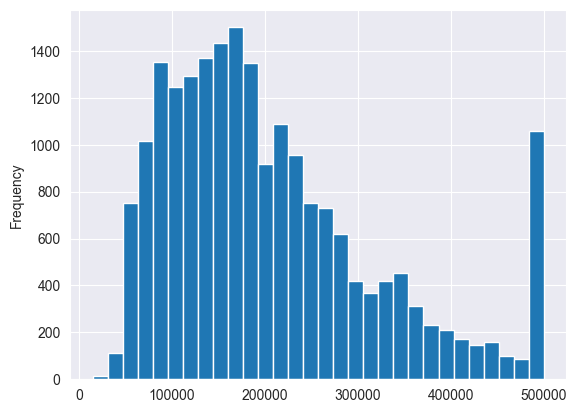

In [6]:
cali['median_house_value'].plot(kind = 'hist', bins = 30)

# the results show a skewed target variable. I should check it's log transform

## Data Cleaning

Before proceeding with our analysis, we need to handle missing values and duplicate entries in our dataset to ensure data quality.


In [7]:
## dropping datasets rows that contain null values:
cali = cali.dropna()
cali = cali.drop_duplicates()

## Log Transformation of Target Variable

Since the target variable (median_house_value) shows a skewed distribution, we'll apply a log transformation using numpy's log1p function (log(1+x)). This transformation can help normalize the distribution and improve model performance.


<Axes: ylabel='Frequency'>

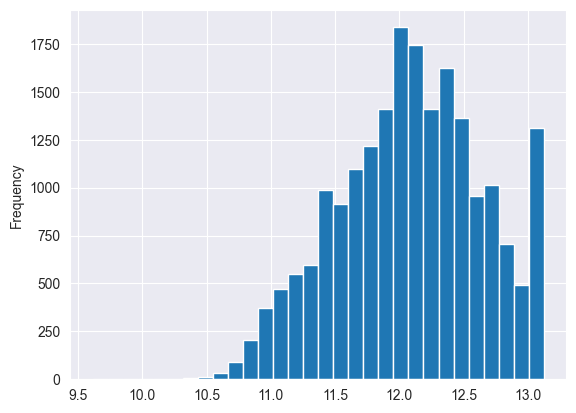

In [8]:
cali['median_house_value_log1p'] = np.log1p(cali['median_house_value'])

# seems slightly better
cali['median_house_value_log1p'].plot(kind = 'hist', bins = 30)


### From now on I will continue with a target variable of the log transformed target variable


## Feature Selection

Now we'll separate our data into features (X) and target variable (y). We'll use the log-transformed target variable and remove both the original and transformed target variables from our feature set.


In [9]:
y = cali['median_house_value_log1p']
X = cali.drop(['median_house_value_log1p', 'median_house_value'] ,axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   ocean_proximity     20433 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.6+ MB


## Ocean proximity is a categorical variable.
I should check it's values and keep in mind that i will transform it with an One Hot Encoder. The other variables should enter the model as Standardised and transformed through the Standard Scaler()


## Categorical Variable Exploration

Let's examine the unique values in our categorical variable 'ocean_proximity'. This will help us understand how to properly encode this variable for our model.


In [10]:
cali['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

## Correlation Analysis

Investigating the correlations between variables and the target variable to identify which features have the strongest relationships with house prices.


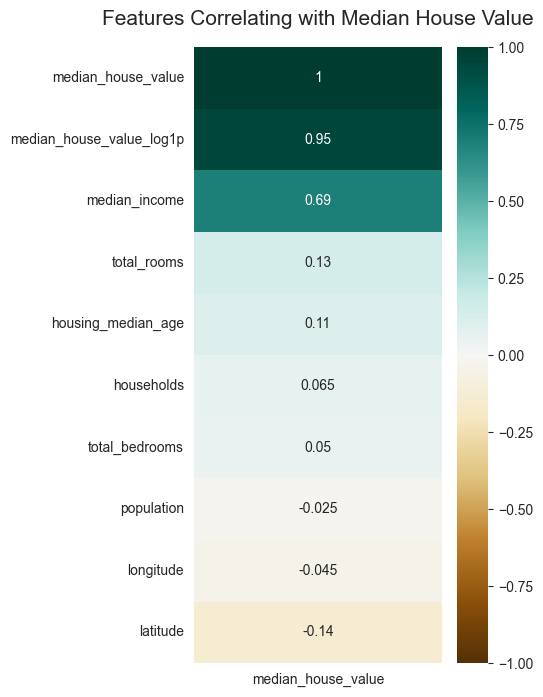

In [11]:
plt.figure(figsize=(4, 8))
heatmap = sns.heatmap(cali.corr(numeric_only=True)[['median_house_value']].sort_values(by='median_house_value', ascending=False)
                      , vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Median House Value', fontdict={'fontsize':15}, pad=16);
# i will keep the median_income variable 

## Categorical Variable Relationship with Target

Let's visualize how the categorical variable 'ocean_proximity' relates to our target variable (log-transformed median house value) using a boxplot. This will help us understand if location relative to the ocean affects house prices.


/var/folders/c8/d6_c0zkx1dx9ycv8s9yl87gr0000gn/T/ipykernel_37619/3208671280.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = cali,


Text(0, 0.5, 'Median House Value - log transformed')

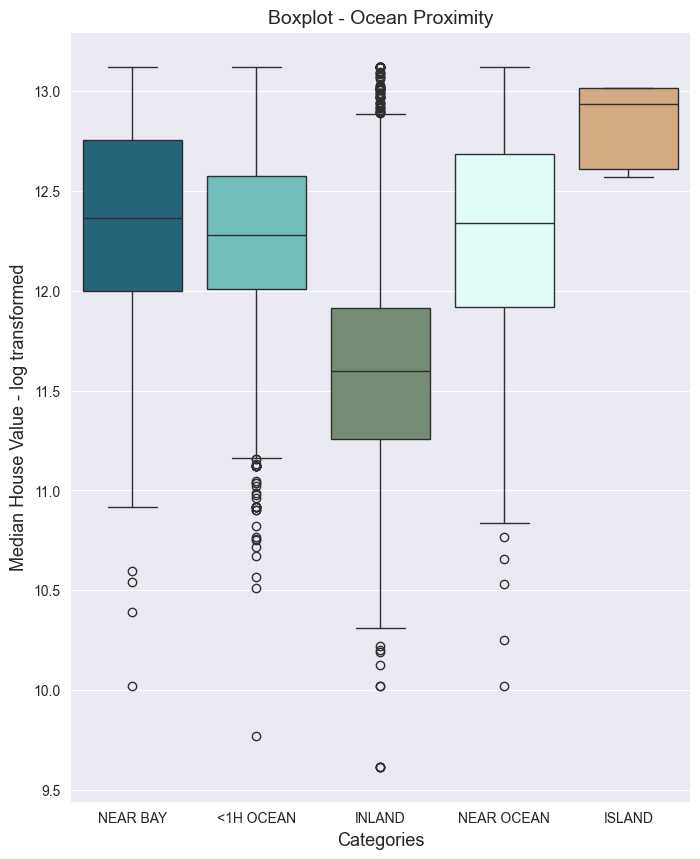

In [12]:
plt.figure(figsize = (8,10))
plt.title("Boxplot - Ocean Proximity", fontsize = 14)
sns.boxplot(data = cali,
            x = 'ocean_proximity', y = 'median_house_value_log1p',
            palette = ['#176B87', '#64CCC5', '#739072','#DAFFFB', '#E1AA74']
            )

plt.xlabel('Categories', fontsize = 13)
plt.ylabel('Median House Value - log transformed', fontsize = 13)

From the plot above I can see that Near Bay, <1H Ocean and Near Ocean 
have similar patterns according to median house value as transformed in a log scale.
So I should  keep in mind to merge these 3 categories into one in a transformer.

## Concluding:
- I will split the data to X, y.
- y variable will be the log trasformed of median value of the house (target variable).
- X variables will be the Ocean Proximity and the median income.
- Next, I will split the data into train and test subsets. The test subset should be 30% of the whole dataset.
- Then, I will create a transformer to later insert it into a pipeline.
- The transformer should pass the Ocean proximity variable, first from a label encoder where the three similar categories will be merged. Later it will pass from an One Hot Encoder.
- In parallel the transformer will create polynomial features for the numeric variable median income, with bias not included


## Data Preparation for Modeling

Now we'll prepare our data for modeling by:
1. Reloading the clean dataset
2. Selecting relevant features (median_income and ocean_proximity)
3. Merging similar ocean_proximity categories based on our boxplot analysis
4. Defining our target variable
5. Splitting the data into training and test sets (70/30 split)


In [13]:
cali = pd.read_csv('data/housing.csv')
cali = cali.dropna()
cali = cali.drop_duplicates()
#cali['median_house_value_log1p'] = np.log1p(cali['median_house_value'])

X = cali[['median_income', 'ocean_proximity']]
# merging categories of similar characteristics into one:
X[['ocean_proximity']] = X[['ocean_proximity']].replace(to_replace=['NEAR BAY', '<1H OCEAN','NEAR OCEAN'], value = 'NEAR OCEAN NEW')
print(X['ocean_proximity'].unique())


y = cali['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

['NEAR OCEAN NEW' 'INLAND' 'ISLAND']


/var/folders/c8/d6_c0zkx1dx9ycv8s9yl87gr0000gn/T/ipykernel_37619/1639056040.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['ocean_proximity']] = X[['ocean_proximity']].replace(to_replace=['NEAR BAY', '<1H OCEAN','NEAR OCEAN'], value = 'NEAR OCEAN NEW')


## Model Building and Pipeline Creation

Here we define a function to create our modeling pipeline. The pipeline includes:
1. A column transformer that:
   - Applies OneHotEncoder to the categorical 'ocean_proximity' variable
   - Applies PolynomialFeatures to the numerical 'median_income' variable
2. A Linear Regression model as the final estimator
3. Optional log transformation of the target variable

The function allows us to specify the degree of polynomial features and whether to use log transformation of the target.


In [14]:
def pipeline_reg(poly_degree = 2, target_log_transform = False):
    # transformer initialisation
    transformer = make_column_transformer( (OneHotEncoder(drop = 'if_binary'),['ocean_proximity']),
                                           (PolynomialFeatures(degree = poly_degree, include_bias= False), ['median_income']),
                                           remainder='passthrough'
                                          )

    # pipeline with Linear Regression Estimator
    pipeln = Pipeline([
        ('transformer', transformer),
        ('lnreg', LinearRegression())
    ])

    if target_log_transform == True: pipeln.fit(X_train, np.log1p(y_train))        
    else: pipeln.fit(X_train, y_train)

    return pipeln

## Model Evaluation with Log-Transformed Target

Now we'll evaluate our model's performance using a log-transformed target variable. We'll:
1. Create models with different polynomial degrees (1-14)
2. Calculate training and test MSE (Mean Squared Error) and R² for each model
3. Plot the results to identify the optimal polynomial degree
4. Look for the point where test error starts to increase (overfitting)

This approach helps us understand how model complexity affects performance and identify the best polynomial degree.


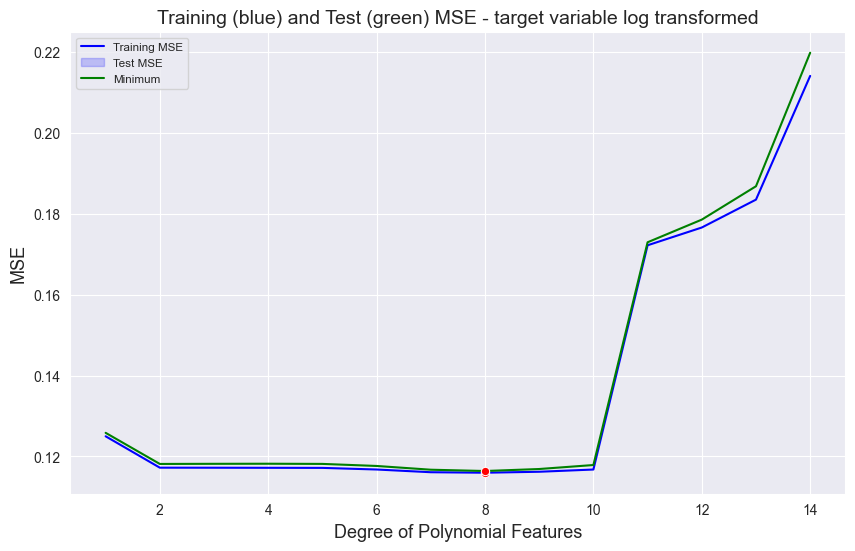

In [15]:
r2_train = []
mse_train = []

r2_test = []
mse_test = []
i_range = []
for i in range(1, 15):
    model = pipeline_reg(poly_degree = i, target_log_transform=True)
    # training MSE  and r2
    r2_train.append(r2_score(model.predict(X_train), np.log1p(y_train)))
    mse_train.append(mean_squared_error(model.predict(X_train),np.log1p(y_train)))
    # test MSE and r2
    r2_test.append(r2_score(model.predict(X_test), np.log1p(y_test)))
    mse_test.append(mean_squared_error(model.predict(X_test),np.log1p(y_test)))
    i_range.append(i)

fig , ax = plt.subplots(figsize=(10,6))
plt.title('Training (blue) and Test (green) MSE - target variable log transformed', fontsize = 14)
ax = sns.lineplot(x = i_range, y = mse_train, color = 'b')
ax = sns.lineplot(x = i_range, y = mse_test, color = 'g')
ax = sns.lineplot(x = [mse_train.index(min(mse_train))+1] , y = [min(mse_train)], color = 'r', markers = True, marker = 'o')
ax = sns.lineplot(x = [mse_test.index(min(mse_test))+1] , y = [min(mse_test)], color = 'r', markers = True, marker = 'o')
ax.set_xlabel('Degree of Polynomial Features', fontsize=13)
ax.set_ylabel('MSE', fontsize=13)
ax.grid(True)
plt.legend(["Training MSE","Test MSE", "Minimum"], fontsize="small")

## Model Evaluation with Non-Transformed Target

Now we'll evaluate our model's performance using the original (non-transformed) target variable. This allows us to compare with the log-transformed approach and determine which works better for our data.

We'll follow the same process:
1. Create models with different polynomial degrees (1-14)
2. Calculate training and test MSE and R² for each model
3. Plot the results to identify the optimal polynomial degree
4. Compare with the log-transformed results


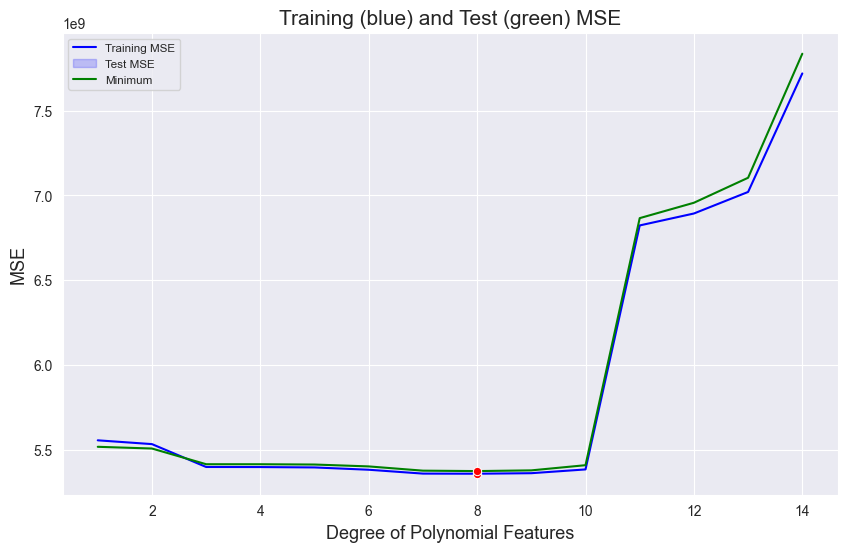

In [16]:
r2_train = []
mse_train = []

r2_test = []
mse_test = []
i_range = []
for i in range(1,15):
    model = pipeline_reg(poly_degree = i, target_log_transform = False)
    # training MSE  and r2
    r2_train.append(r2_score(model.predict(X_train), y_train))
    mse_train.append(mean_squared_error(model.predict(X_train),y_train))
    # test MSE and r2
    r2_test.append(r2_score(model.predict(X_test), y_test))
    mse_test.append(mean_squared_error(model.predict(X_test),y_test))
    i_range.append(i)

fig , ax = plt.subplots(figsize=(10,6))
plt.title('Training (blue) and Test (green) MSE', fontsize = 15)
ax = sns.lineplot(x = i_range, y = mse_train, color = 'b')
ax = sns.lineplot(x = i_range, y = mse_test, color = 'g')
ax = sns.lineplot(x = [mse_train.index(min(mse_train))+1] , y = [min(mse_train)], color = 'r', markers = True, marker = 'o')
ax = sns.lineplot(x = [mse_test.index(min(mse_test))+1] , y = [min(mse_test)], color = 'r', markers = True, marker = 'o')
ax.set_xlabel('Degree of Polynomial Features', fontsize=13)
ax.set_ylabel('MSE', fontsize=13)
ax.grid(True)
plt.legend(["Training MSE","Test MSE", "Minimum"], fontsize="small")

From the graphs above I decided to keep the NON log transformed target variable with a degree of 8 in PolynomialFeatures

In [17]:
model_lr = pipeline_reg(poly_degree = 8, target_log_transform = False)

model_lr

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['ocean_proximity']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(degree=8,
                                                                     include_bias=False),
                                                  ['median_income'])])),
                ('lnreg', LinearRegression())])

Text(0.5, 0, 'Feature')

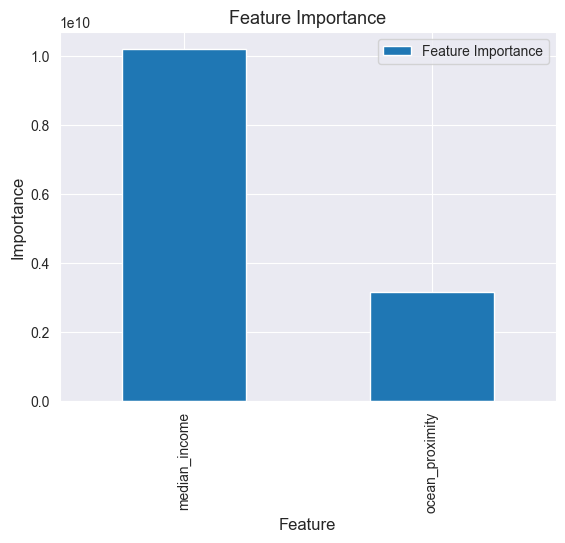

In [18]:
importance = permutation_importance(model_lr, X_test, y_test, n_repeats = 30, random_state = 42, scoring = 'neg_mean_squared_error')

dictionary1 = { 
               "Feature Importance": importance['importances_mean'],
               "Feature": X_test.columns
              }

pd.DataFrame(dictionary1).set_index('Feature').plot(kind = 'bar')
plt.title('Feature Importance', fontsize = 13)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12)


I will remind myself which are the most related variables to my target:

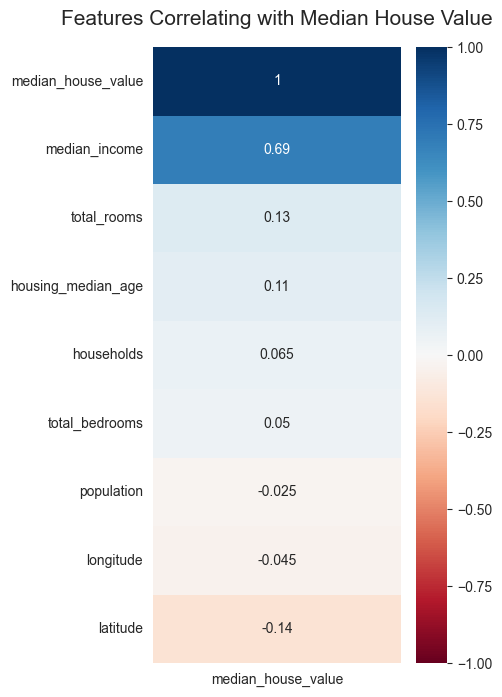

In [19]:
plt.figure(figsize=(4, 8))
heatmap = sns.heatmap(cali.corr(numeric_only = True)[['median_house_value']].sort_values(by='median_house_value', ascending=False)
                      , vmin=-1, vmax=1, annot=True, cmap='RdBu')
heatmap.set_title('Features Correlating with Median House Value', fontdict={'fontsize':15}, pad=16);

I will add to my inputs the total rooms and housing median age variables.

In [20]:
cali = pd.read_csv('data/housing.csv')
cali = cali.dropna()
cali = cali.drop_duplicates()

X = cali[['median_income', 'ocean_proximity', 'total_rooms', 'housing_median_age']]
# merging categories of similar characteristics into one:
X[['ocean_proximity']] = X[['ocean_proximity']].replace(to_replace=['NEAR BAY', '<1H OCEAN','NEAR OCEAN'], value = 'NEAR OCEAN NEW')
print(X['ocean_proximity'].unique())

y = cali['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

['NEAR OCEAN NEW' 'INLAND' 'ISLAND']


/var/folders/c8/d6_c0zkx1dx9ycv8s9yl87gr0000gn/T/ipykernel_37619/509823253.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['ocean_proximity']] = X[['ocean_proximity']].replace(to_replace=['NEAR BAY', '<1H OCEAN','NEAR OCEAN'], value = 'NEAR OCEAN NEW')


In [21]:
def pipeline_reg_4inputs(poly_degree = 2, target_log_transform = False):
    # transformer initialisation
    transformer = make_column_transformer( (OneHotEncoder(drop = 'if_binary'),['ocean_proximity']),
                                           (PolynomialFeatures(degree = poly_degree, include_bias= False), ['median_income','total_rooms','housing_median_age']),
                                           remainder='passthrough'
                                           )

    # pipeline with Linear Regression Estimator
    pipeln = Pipeline([
        ('transformer', transformer),
        ('lnreg', LinearRegression())
    ])

    if target_log_transform == True: pipeln.fit(X_train, np.log1p(y_train))
    else: pipeln.fit(X_train, y_train)

    return pipeln

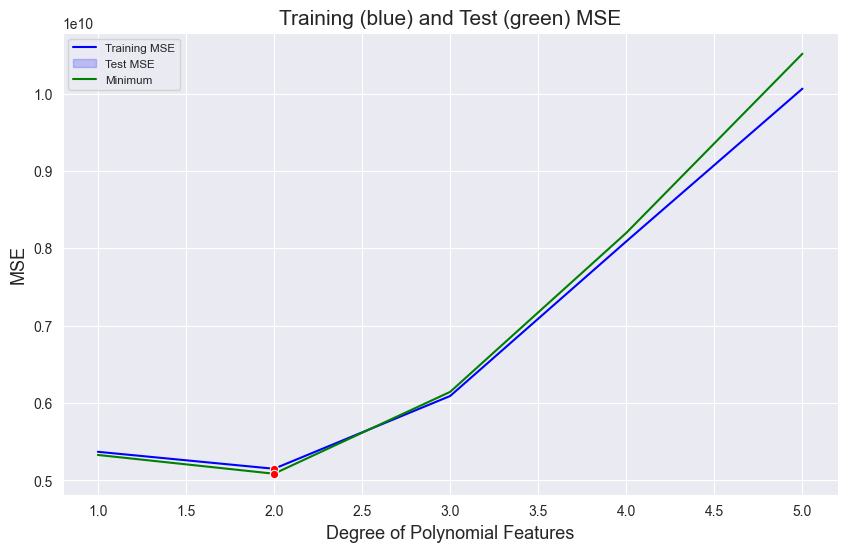

In [22]:
r2_train = []
mse_train = []

r2_test = []
mse_test = []
i_range = []
for i in range(1,6):
    model = pipeline_reg_4inputs(poly_degree = i, target_log_transform = False)
    # training MSE  and r2
    r2_train.append(r2_score(model.predict(X_train), y_train))
    mse_train.append(mean_squared_error(model.predict(X_train),y_train))
    # test MSE and r2
    r2_test.append(r2_score(model.predict(X_test), y_test))
    mse_test.append(mean_squared_error(model.predict(X_test),y_test))
    i_range.append(i)

fig , ax = plt.subplots(figsize=(10,6))
plt.title('Training (blue) and Test (green) MSE', fontsize = 15)
ax = sns.lineplot(x = i_range, y = mse_train, color = 'b')
ax = sns.lineplot(x = i_range, y = mse_test, color = 'g')
ax = sns.lineplot(x = [mse_train.index(min(mse_train))+1] , y = [min(mse_train)], color = 'r', markers = True, marker = 'o')
ax = sns.lineplot(x = [mse_test.index(min(mse_test))+1] , y = [min(mse_test)], color = 'r', markers = True, marker = 'o')
ax.set_xlabel('Degree of Polynomial Features', fontsize=13)
ax.set_ylabel('MSE', fontsize=13)
ax.grid(True)
plt.legend(["Training MSE","Test MSE", "Minimum"], fontsize="small")

## Final Model Selection

Based on the evaluation results, we'll select a model with polynomial degree 2 using the non-transformed target and our enhanced feature set (which includes median_income, ocean_proximity, total_rooms, and housing_median_age). This model provides a good balance between complexity and performance, avoiding overfitting while capturing the underlying patterns in the data.


In [23]:
model_lr_4in = pipeline_reg_4inputs(poly_degree = 2, target_log_transform = False)

model_lr_4in 

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['ocean_proximity']),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['median_income',
                                                   'total_rooms',
                                                   'housing_median_age'])])),
                ('lnreg', LinearRegression())])

## Feature Importance Analysis

Now that we have our final model, we'll analyze feature importance to understand which features contribute most to the model's predictions. We'll use permutation importance, which measures how much the model's performance decreases when a feature's values are randomly shuffled.

This analysis helps us:
1. Understand which features are most influential in predicting house prices
2. Identify potential areas for feature engineering
3. Potentially simplify the model by focusing on the most important features


Text(0.5, 0, 'Feature')

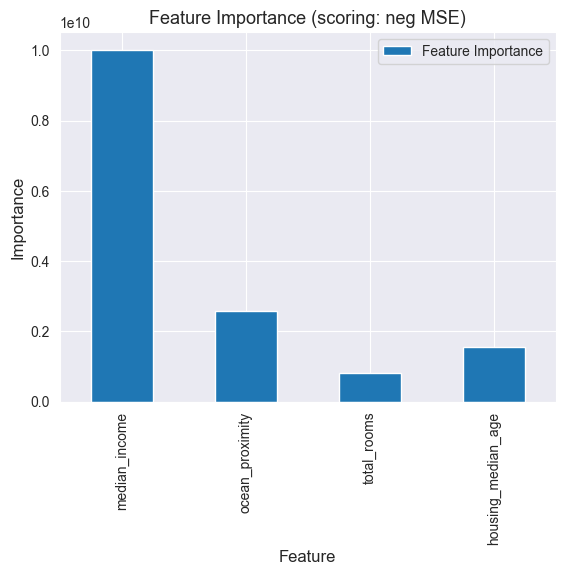

In [24]:
importance2 = permutation_importance(model_lr_4in, X_test, y_test, n_repeats = 30, random_state = 42, scoring = 'neg_mean_squared_error')

dictionary1 = {
    "Feature Importance": importance2['importances_mean'],
    "Feature": X_test.columns
}

pd.DataFrame(dictionary1).set_index('Feature').plot(kind = 'bar')
plt.title('Feature Importance (scoring: neg MSE)', fontsize = 13)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12)

## Alternative Feature Importance Metric (R²)

To get a more comprehensive understanding of feature importance, we'll also calculate permutation importance using R² (coefficient of determination) as the scoring metric. This provides a different perspective on feature importance, focusing on how much each feature contributes to the model's explanatory power rather than error reduction.

Comparing the results from different metrics helps ensure our conclusions about feature importance are robust.


Text(0.5, 0, 'Feature')

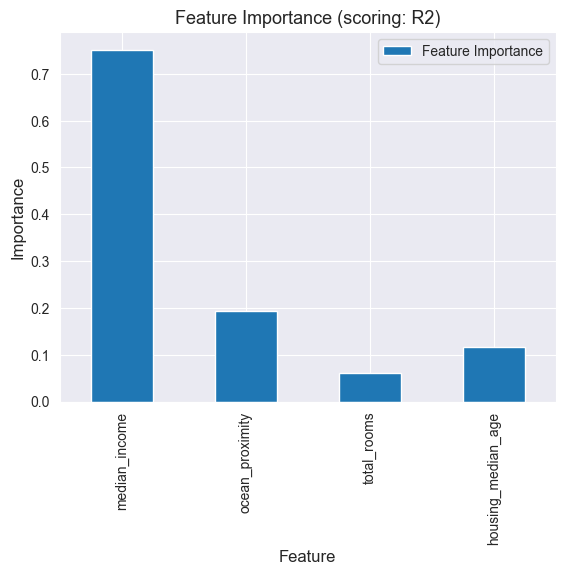

In [25]:
importance3 = permutation_importance(model_lr_4in, X_test, y_test, n_repeats = 30, random_state = 42, scoring = 'r2')

dictionary1 = {
    "Feature Importance": importance3['importances_mean'],
    "Feature": X_test.columns
}

pd.DataFrame(dictionary1).set_index('Feature').plot(kind = 'bar')
plt.title('Feature Importance (scoring: R2)', fontsize = 13)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12)

## Model Coefficients Visualization

While permutation importance tells us which features are most important for prediction, examining the model coefficients provides insight into how each feature affects the predicted house price. 

In this visualization, we'll:
1. Extract the coefficients from our linear regression model
2. Match them with their corresponding feature names from the transformer
3. Create a bar plot showing the magnitude and direction of each coefficient
4. Sort them to easily identify the most influential features

This helps us understand not just which features are important, but how they relate to the target variable.


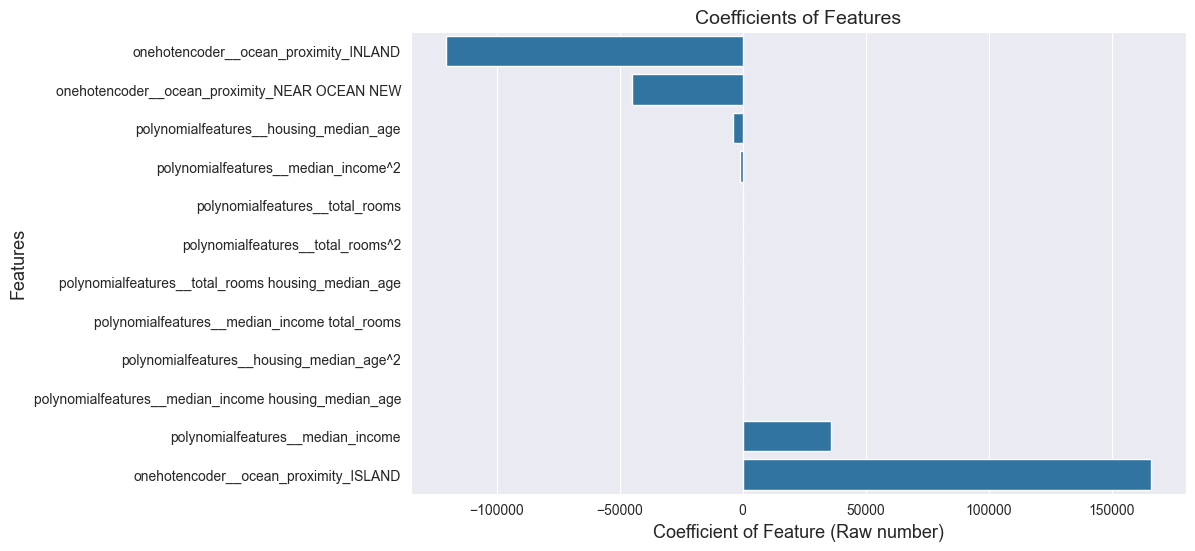

In [26]:
dictionary_temp = {
    'Feature':model_lr_4in.named_steps['transformer'].get_feature_names_out(),
    'Coefficient':model_lr_4in.named_steps['lnreg'].coef_
}
coefs = pd.DataFrame(dictionary_temp)

plt.figure(figsize = (10,6))
plt.title('Coefficients of Features', fontsize = 14)
sns.barplot(data = coefs.sort_values(by = 'Coefficient'), x = 'Coefficient', y = 'Feature' )
plt.ylabel('Features', fontsize = 13)
plt.xlabel('Coefficient of Feature (Raw number)', fontsize = 13);



## Relationship Visualization

To better understand the relationship between our most important feature (median_income) and the target variable (median_house_value), we'll create a density plot. This visualization shows:

1. The joint distribution of median income and house values
2. Areas of high density (where most data points are concentrated)
3. The overall pattern of the relationship (linear, non-linear, etc.)

This helps us validate our model's approach and understand why median_income is such an important predictor.


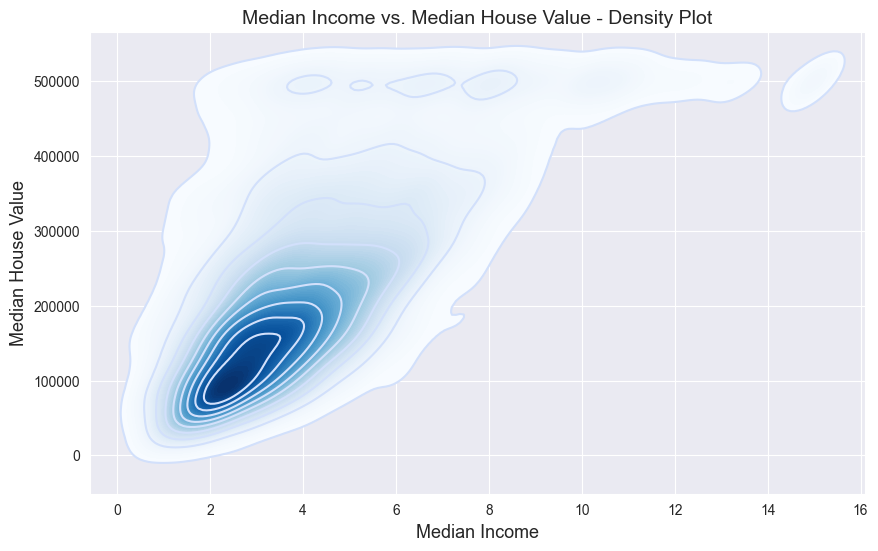

In [27]:
plt.figure(figsize=(10,6))
plt.title('Median Income vs. Median House Value - Density Plot', fontsize = 14)
plt.xlabel('Median Income', fontsize = 13)
plt.ylabel('Median House Value', fontsize = 13)
sns.kdeplot(x = X['median_income'], y = y, fill=True, levels=100, cmap="Blues", thresh = 0.01)
sns.kdeplot(x = X['median_income'], y = y, color = '#D2E0FB', thresh = 0.01);

## Simple Linear Regression Feature Importance

As a final comparison, we'll build a simpler linear regression model without polynomial features or the categorical ocean_proximity variable. This helps us:

1. Validate our findings from the more complex model
2. See if the same features remain important in a simpler context
3. Understand the baseline importance of features without transformations

This comparison provides additional confidence in our feature importance conclusions and helps identify which features are consistently important across different model specifications.


Text(0.5, 0, 'Feature')

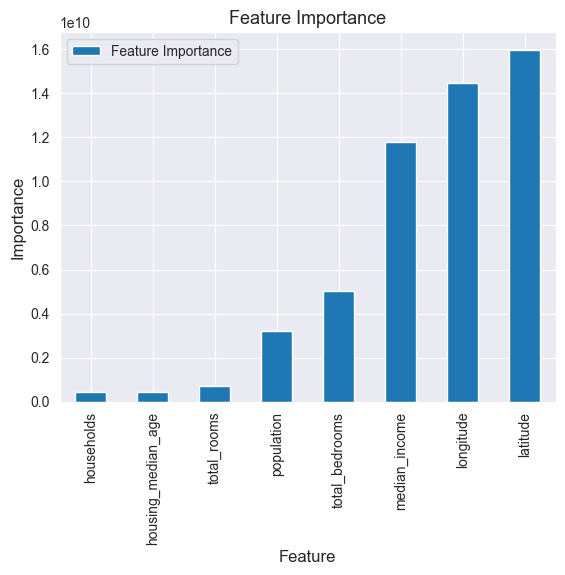

In [28]:
#testing dummy linear regression Features' importance -  here I drop Ocean Proximity variable
cali = pd.read_csv('data/housing.csv')
cali = cali.dropna()
cali = cali.drop_duplicates()

y = cali['median_house_value']
X = cali.drop(['median_house_value', 'ocean_proximity'], axis = 1) 



##

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True)

mdummy = LinearRegression()
mdummy.fit(X_train, y_train)


importance_dummy = permutation_importance(mdummy, X_test, y_test, n_repeats = 30, random_state = 42, scoring = 'neg_mean_squared_error')

dictionaryd = {
    "Feature Importance": importance_dummy['importances_mean'],
    "Feature": X_test.columns
}

pd.DataFrame(dictionaryd).set_index('Feature').sort_values(by = 'Feature Importance').plot(kind = 'bar')
plt.title('Feature Importance', fontsize = 13)
plt.ylabel('Importance', fontsize = 12)
plt.xlabel('Feature', fontsize = 12)


## Conclusion

In this notebook, we built and interpreted a regression model to predict house prices in California. Our analysis revealed several key insights:

### Model Selection
- We found that a polynomial degree of 3 provided the best balance between model complexity and performance
- Using the original (non-transformed) target variable yielded better results than the log-transformed version
- Including additional features (total_rooms, housing_median_age) improved model performance

### Feature Importance
- **Median Income** consistently emerged as the most important predictor of house prices across all models and metrics
- **Ocean Proximity** (location relative to the ocean) was also a significant factor
- The relationship between median income and house prices showed a clear positive correlation
- The importance of features was consistent across different model specifications and evaluation metrics

### Implications
- For real estate valuation in California, income levels in an area are the strongest predictor of house prices
- Location relative to the ocean significantly affects property values
- The polynomial relationship between features and house prices suggests non-linear pricing dynamics in the real estate market

This analysis demonstrates the value of feature engineering and model interpretation techniques in understanding the factors that drive house prices in California.
